# Домашняя работа №1. Часть №1. Обучение CBOW-модели Word2vec.

Был написан код для обучения модели: [src/cbow_ns.py](../src/cbow_ns.py)

Рассмотрим кривую обучения CBOW Word2Vec:

In [5]:
import sys
sys.path.insert(0, "../src")

import numpy as np
import pandas as pd
import pickle as pkl
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


In [6]:
with open("../data/prepared.pkl", "rb") as fp:
    prepared = pkl.load(fp)
vocabulary = prepared["vocabulary"]
texts = prepared["texts"]
contexts = prepared["contexts"]
test_texts = prepared["test_texts"]
y_train = prepared["y_train"]
y_test = prepared["y_test"]
text_train = prepared["texts_train"]
text_test = prepared["texts_test"]


# 1. Кривые обучения

## CBOW

In [4]:
d_metrics = pd.read_csv("../reported_metrics/cbow_metrics.csv")

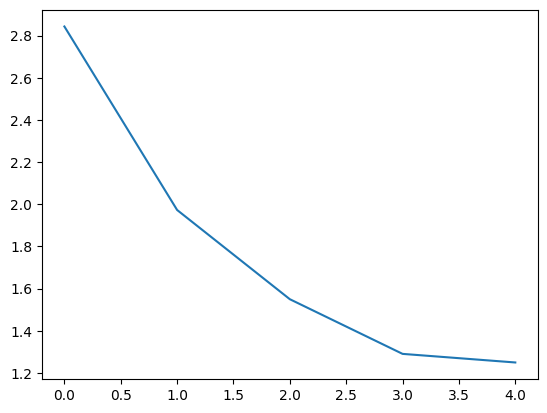

In [5]:
d_train = d_metrics[["epoch", "train_loss_epoch"]].dropna()
plt.plot(d_train.epoch, d_train.train_loss_epoch)
plt.show()


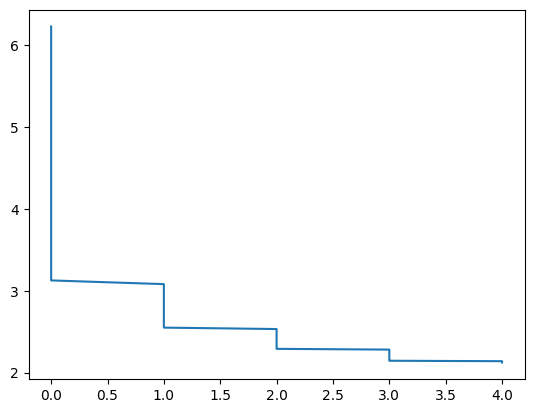

In [6]:
d_val = d_metrics[["epoch", "val_loss_epoch"]].dropna()
plt.plot(d_val.epoch, d_val.val_loss_epoch)
plt.show()


# Тестируем модель

In [2]:
import torch as th
from types import NoneType
from razdel import tokenize
from typing import Union, Mapping, Any
from pytorch_lightning import LightningModule


class CBOWModel(LightningModule):
    def __init__(self, vocab_size=71186, embedding_dim=128):
        super().__init__()
        self.embeddings = th.nn.Embedding(vocab_size, embedding_dim)
        self.out_layer = th.nn.Linear(embedding_dim, vocab_size)
        self.loss = th.nn.CrossEntropyLoss()
        self.train_outputs = []
        self.val_outputs = []
        self.test_outputs = []
    
    def forward(self, centrals, contexts):
        projections = self.embeddings.forward(contexts).sum(axis=1)
        logits = self.out_layer.forward(projections)
        loss = self.loss(logits, centrals.squeeze())
        return loss
    
    def training_step(self, batch, batch_nb):
        result = self(*batch)
        self.log("loss", result)
        return {'loss': result}
    
    def validation_step(self, batch, batch_nb):
        result = self(*batch)
        self.log("val_loss", result)  
        return {'val_loss': result}

    def test_step(self, batch, batch_nb):
        result = self(*batch)
        self.log("test_loss", result)
        return {'test_loss': self(*batch)}

    def on_train_batch_end(
        self,
        outputs: Union[th.Tensor, Mapping[str, Any], NoneType],
        batch: Any,
        batch_idx: int,
        dataloader_idx: int = 0,
    ) -> None:
        self.train_outputs.append(outputs)
    
    def on_train_epoch_end(self):
        outputs = self.train_outputs
        avg_loss = th.stack([x['loss'] for x in outputs]).mean()
        tensorboard_logs = {'loss': avg_loss}
        self.log("train_loss_epoch", avg_loss, on_step=False, on_epoch=True)
        return {'train_loss_epoch': avg_loss, 'progress_bar': tensorboard_logs}
    
    def on_validation_batch_end(
        self,
        outputs: Union[th.Tensor, Mapping[str, Any], NoneType],
        batch: Any,
        batch_idx: int,
        dataloader_idx: int = 0,
    ) -> None:
        self.val_outputs.append(outputs)
    
    def on_validation_epoch_end(self):
        outputs = self.val_outputs
        avg_loss = th.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        self.log("val_loss_epoch", avg_loss, on_step=False, on_epoch=True)
        return {'val_loss_epoch': avg_loss, 'progress_bar': tensorboard_logs}

    def on_test_batch_end(
        self,
        outputs: Union[th.Tensor, Mapping[str, Any], NoneType],
        batch: Any,
        batch_idx: int,
        dataloader_idx: int = 0,
    ) -> None:
        self.test_outputs.append(outputs)
    
    def on_test_epoch_end(self):
        outputs = self.test_outputs 
        avg_loss = th.stack([x['test_loss'] for x in outputs]).mean()
        tensorboard_logs = {'test_loss': avg_loss}
        self.log("test_loss_epoch", avg_loss, on_step=False, on_epoch=True)
        return {'test_loss_epoch': avg_loss, 'progress_bar': tensorboard_logs}
    
    def configure_optimizers(self):
        optimizer = th.optim.Adam(self.parameters(), lr=1e-4)
        return [optimizer]


def get_emb_by_text(embeddings, vocabulary, phrase):
    embeddings = np.array(
        [
            embeddings[vocabulary.get_index(word.text.lower())] 
            for word in tokenize(phrase)
        ]
    )
    return np.mean(embeddings, axis=0)


def get_emb_by_tokens(embeddings, vocabulary, tokens):
    vectors = []
    for tok in tokens:
        idx = vocabulary.get_index(tok)
        vec = embeddings[idx,:] 
        vectors.append(vec)
    return np.mean(np.array(vectors), axis=0)


/home/fatuus/advanced-nlp/prj04_emb/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
# PATH_MODEL = "../nb/ckpt/w06-epoch=9-val_loss=-98685.14.ckpt"
# PATH_MODEL = "../lightning_logs/[cbow][20240409034039]/ckpt/last.ckpt"
PATH_MODEL = "../lightning_logs/[cbow][20240409034039]/ckpt/epoch=4-val_loss=1.70.ckpt"
# PATH_MODEL ="../lightning_logs/[cbow_ns][20240414101659]/ckpt/last.ckpt"
model = CBOWModel.load_from_checkpoint(PATH_MODEL).eval()
embeddings = model.embeddings.weight.cpu().data.numpy()


In [43]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def most_similar(embeddings, vocabulary, word):
    word_emb = embeddings[vocabulary.get_index(word)]
    similarities = cosine_similarity([word_emb], embeddings)[0]
    top10 = np.argsort(similarities)[-10:]
    return [vocabulary.get_word(index) for index in reversed(top10)]

most_similar(embeddings, vocabulary, 'путин')

['путин',
 'андерлехт',
 'австрийских',
 'колоссальная',
 'мордашова',
 'лес',
 'капсула',
 'утверждали',
 'федеративной',
 'линдберг']

In [44]:
X_train = np.zeros((len(text_train), embeddings.shape[1]))
for i, text in enumerate(text_train):
    X_train[i, :] = get_emb_by_tokens(embeddings, vocabulary, text)

X_test = np.zeros((len(text_test), embeddings.shape[1]))
for i, text in enumerate(text_test):
    X_test[i, :] = get_emb_by_text(embeddings, vocabulary, text)

print(X_train.shape)
print(y_train.shape)


(63356, 128)
(63356,)


In [45]:
est = lgb.LGBMClassifier(
    n_estimators=500,
    subsample=0.6,
    max_depth=2,
    min_child_samples=1000
)
est.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 63356, number of used features: 128
[LightGBM] [Info] Start training from score -1.759365
[LightGBM] [Info] Start training from score -2.641586
[LightGBM] [Info] Start training from score -2.885491
[LightGBM] [Info] Start training from score -2.620108
[LightGBM] [Info] Start training from score -3.145201
[LightGBM] [Info] Start training from score -3.347217
[LightGBM] [Info] Start training from score -2.951821
[LightGBM] [Info] Start training from score -2.638048
[LightGBM] [Info] Start training from score -1.817986
[LightGBM] [Info] Start training from score -2.249951
[LightGBM] [Info] Start training from score -2.476545
[LightGBM] [Info] Start training from score -2.600994
[LightGBM] [Warning] No further splits with positive gain, be

LGBMClassifier(max_depth=2, min_child_samples=1000, n_estimators=500,
               subsample=0.6)

In [47]:
p_train = est.predict_proba(X_train)
cbow_train = roc_auc_score(y_true=y_train, y_score=p_train, multi_class="ovo")


In [48]:
p_test = est.predict_proba(X_test)
cbow_test = roc_auc_score(y_true=y_test, y_score=p_test, multi_class="ovo")


In [1]:
pd.DataFrame# cbow_train, cbow_test

NameError: name 'pd' is not defined